<a href="https://colab.research.google.com/github/rayshu/Data-Classification/blob/master/Classifiers_NB_RF_SVM_LR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Exploration

In [0]:
import pandas as pd
df = pd.read_csv('/content/drive/My Drive/Data/cleaneddata.csv')

In [0]:
df_ent = df.loc[(df['DocType']=="Public") | (df["DocType"]=="Private"),:]
df_nent = df.loc[df["DocType"]=="NE",:]

In [0]:
doctype_to_id = {'Private': 1, 'Public': 0}

In [5]:
df_ent['DocType_id'] = df_ent['DocType'].map({'Private': 1, 'Public': 0})
df_ent

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Text,DocType,DocType_id
0,confirm usf mnd significant action mnc mnd eve...,Private,1
1,joint defense operation center receive report ...,Private,1
2,c small arm fire attack contractor set convoy ...,Private,1
3,c small arm fire attack contractor set convoy ...,Private,1
4,personal security detail travel north along ma...,Private,1
...,...,...,...
480,fifth year run dyncorp international llc di re...,Public,0
481,dyncorp international di gain important govern...,Public,0
482,january dyncorp international di one first com...,Public,0
483,november g job magazine ranked dyncorp interna...,Public,0


In [6]:
df_nent['DocType_id'] = df_nent['DocType'].map({'NE' : 0})
df_nent

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Text,DocType,DocType_id
485,idaho vandal idaho vandal intercollegiate athl...,NE,0
486,robert l may robert lewis may july august crea...,NE,0
487,indycar series izod indycar series premier lev...,NE,0
488,philippine nationality law philippine national...,NE,0
489,takeichi nishi colonel baron imperial japanese...,NE,0
...,...,...,...
10487,dice los angeles dice los angeles formerly kno...,NE,0
10488,spirit radio spirit radio song release canadia...,NE,0
10489,gm degree v engine general motor opel subsidia...,NE,0
10490,muzaffarabad muzaffarabad pahari potwari capit...,NE,0


# Imbalanced Classes

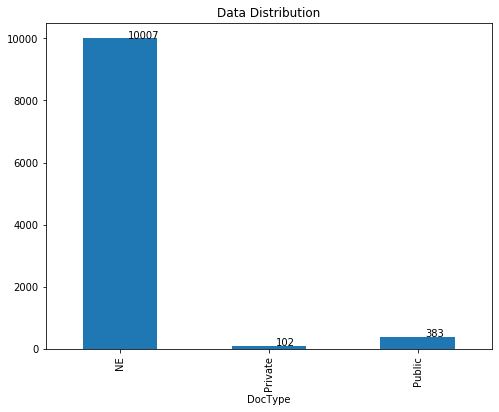

In [7]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
graph = df.groupby('DocType').Text.count().plot.bar(ylim=0)

for p in graph.patches:
        graph.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()))
graph.set_title('Data Distribution') 
plt.show()

## Undersampling 

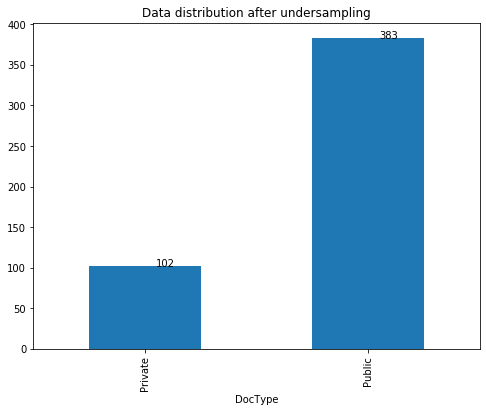

In [8]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
graph = df_ent.groupby('DocType').Text.count().plot.bar(ylim=0)

for p in graph.patches:
        graph.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()))
graph.set_title('Data distribution after undersampling') 
plt.show()


# Text Representation

* The classifiers can't directly process the text documents in their original form, as most of them expect numerical feature vectors with a fixed size.
* *sublinear_tf* is set to True to use a logarithmic form for frequency.
* *min_df* is the minimum numbers of documents a word must be present in to be kept.
* *norm* is set to l2, to ensure all our feature vectors have a euclidian norm of 1.
* *ngram_range* is set to (1, 2) to indicate that we want to consider both unigrams and bigrams.
* *stop_words* is set to "english" to remove all common pronouns ("a", "the", ...) to reduce the number of noisy features.

### tf-idf vectors for df_ent 

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='ISO-8859-1', ngram_range=(1, 2))
# tfidf = TfidfVectorizer(ngram_range=(1, 2))
features = tfidf.fit_transform(df_ent.Text).toarray()
labels = df_ent.DocType_id
print(features.shape[0] , "'Text' is represented by", features.shape[1], "features.")

485 'Text' is represented by 3793 features.


### tf-idf vectors for df_nent

In [0]:
# features_nent = tfidf.fit_transform(df_nent.Text).toarray()
# # labels_nent = df_nent.DocType_id
# print(features_nent.shape[0] , "'Text' is represented by", features_nent.shape[1], "features.")

# Most corelated terms in each class

In [12]:
from sklearn.feature_selection import chi2
import numpy as np
N = 10
# file = open('/content/drive/My Drive/Data/corelatedTerms_tfidf.txt', 'w+')
for DocType, DocType_id in sorted(doctype_to_id.items()):
  features_chi2 = chi2(features, labels == DocType_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("\n# \033[1m {}:".format(DocType), "\033[0m ")
  print("Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))
    
#     file.write("\n\n# {}:".format(DocType))
#     file.write("\nMost correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
#     file.write("\nMost correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))
# file.close()


#  Private:  
Most correlated unigrams:
. grid
. vehicle
. device
. improvised
. reconstruction
. convoy
. explosive
. afghan
. police
. provincial
Most correlated bigrams:
. police technical
. advisory team
. arm fire
. small arm
. improvised explosive
. explosive device
. national police
. provincial reconstruction
. reconstruction team
. afghan national

#  Public:  
Most correlated unigrams:
. grid
. vehicle
. device
. improvised
. reconstruction
. convoy
. explosive
. afghan
. police
. provincial
Most correlated bigrams:
. police technical
. advisory team
. arm fire
. small arm
. improvised explosive
. explosive device
. national police
. provincial reconstruction
. reconstruction team
. afghan national


## Naive Bayes Classifier

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(df_ent['Text'], df_ent['DocType'], random_state = 0)
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)
X_test_nent = df_nent['Text']
y_test_nent = df_nent['DocType']
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

X_train:  (363,)
y_train:  (363,)
X_test:  (122,)
y_test:  (122,)


In [28]:
print(clf.predict(count_vect.transform(["rocket attack vicinity adreskan l may one explosion rocket propel grenade hit west wall adreskan forward operating base military grid reference system mt adreskan forward operating base lteton adreskan call sign state tower try get information injury report yet l teton state west wall hit rocket propel grenade fire south camp graveyard dyncorp contractor person account west side wall still stable information source afghan regional security integration command west roc l"])))

['Private']


In [29]:
df_ent[df_ent['Text'] == "rocket attack vicinity adreskan l may one explosion rocket propel grenade hit west wall adreskan forward operating base military grid reference system mt adreskan forward operating base lteton adreskan call sign state tower try get information injury report yet l teton state west wall hit rocket propel grenade fire south camp graveyard dyncorp contractor person account west side wall still stable information source afghan regional security integration command west roc l"]

,Text,DocType,DocType_id
96,rocket attack vicinity adreskan l may one expl...,Private,1


# Model Selection

* Logistic Regression
* (Multinomial) Naive Bayes
* Linear SVC
* Random Forest

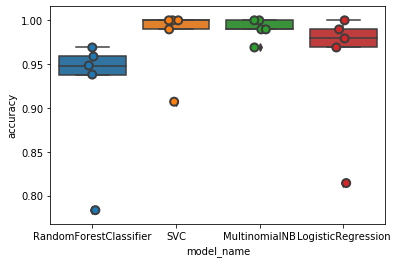

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# from sklearn.svm import LinearSVC
from sklearn import model_selection, svm
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    # LinearSVC(),
    svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto',random_state=0),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [31]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LogisticRegression        0.950515
MultinomialNB             0.989691
RandomForestClassifier    0.919588
SVC                       0.979381
Name: accuracy, dtype: float64

# Model evaluation

In [32]:
data = {'DocType': ['Public', 'Private'], 'doctype_id': [0, 1]}
doctype_id_df = pd.DataFrame.from_dict(data)
doctype_id_df.head()

,DocType,doctype_id
0,Public,0
1,Private,1


In [60]:
from sklearn.metrics import confusion_matrix
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df_ent.index, test_size=0.2, random_state=0)

print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)

precision_public_list = []
precision_private_list = []
recall_public_list = []
recall_private_list = []
f1_public_list = []
f1_private_list = []

X_train:  (388, 3793)
y_train:  (388,)
X_test:  (97, 3793)
y_test:  (97,)


RandomForestClassifier 
 [[78  0]
 [ 6 13]]
SVC 
 [[78  0]
 [ 0 19]]
MultinomialNB 
 [[78  0]
 [ 0 19]]
LogisticRegression 
 [[78  0]
 [ 2 17]]


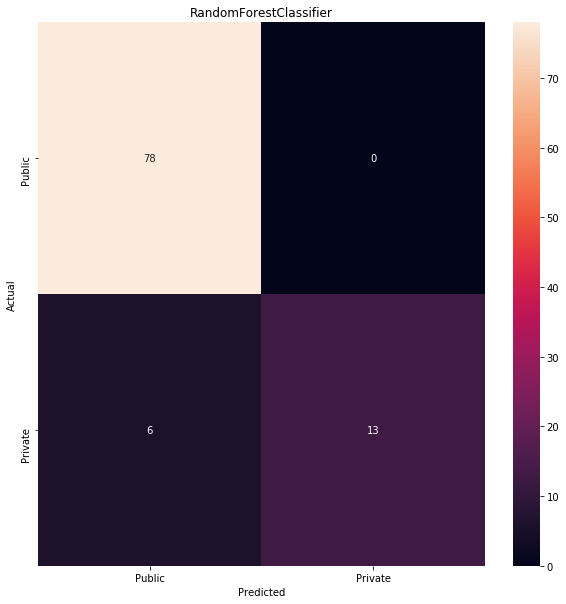

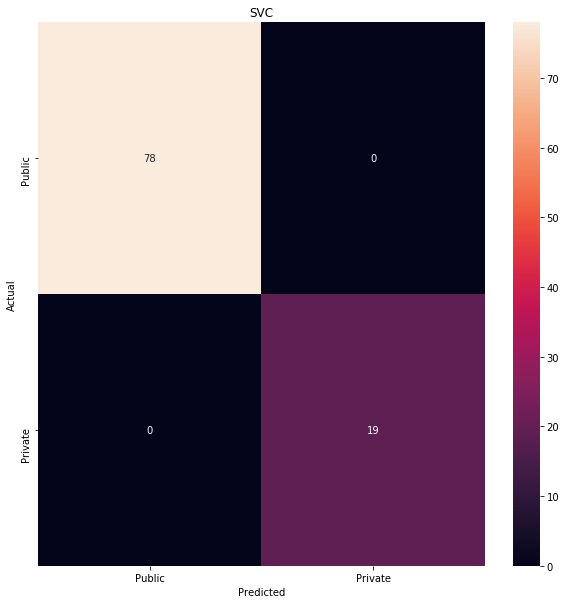

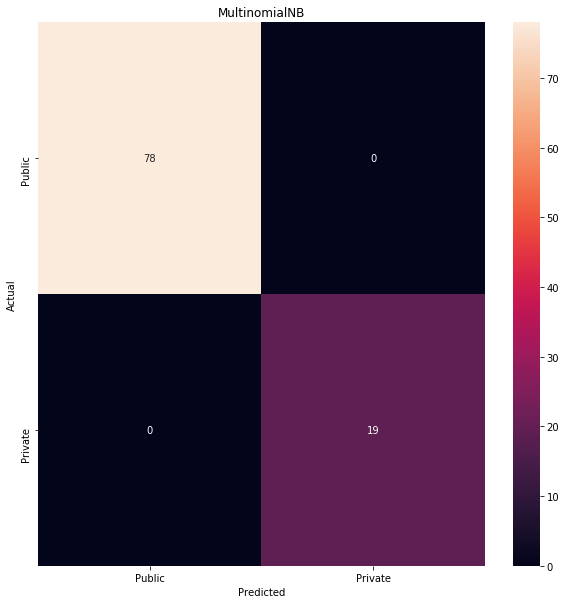

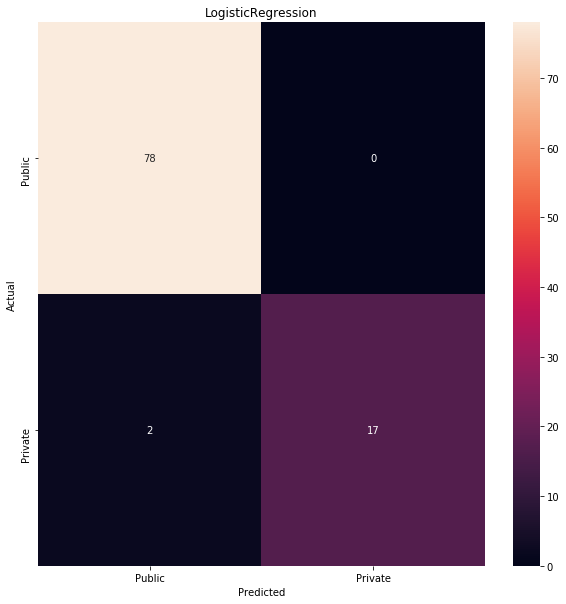

In [61]:
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto',random_state=0)
SVM.fit(Train_X_Tfidf,Train_Y)
for model in models:
    
    model_name = model.__class__.__name__
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    conf_mat = confusion_matrix(y_test, y_pred)
    
    print(model_name, '\n', conf_mat)
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=doctype_id_df.DocType.values, yticklabels=doctype_id_df.DocType.values)
    plt.title(model_name)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    fig.savefig('/content/drive/My Drive/Data/' + model_name + '.png')
    
    True_private = conf_mat[0,0]
    False_private = conf_mat[0,1]
    False_public = conf_mat[1,0]
    True_public = conf_mat[1,1]

    precision_private = round((True_private) / (True_private + False_private), 2)
    recall_private = round((True_private) / (True_private + False_public), 2)
    f1_private = round((2 * precision_private * recall_private) / (precision_private + recall_private), 2)

    precision_public = round((True_public) / (True_public + False_public), 2)
    recall_public = round((True_public) / (True_public + False_private), 2)
    f1_public = round((2 * precision_public * recall_public)/(precision_public + recall_public), 2)


    #writing to list
    precision_private_list.append(precision_private)
    recall_private_list.append(recall_private)
    f1_private_list.append(f1_private)

    precision_public_list.append(precision_public)
    recall_public_list.append(recall_public)
    f1_public_list.append(f1_public)


In [62]:
dict = {'Model':["Random Forest", "Linear Support Vector Classifier", "Multinomial Naive Bayes", "Logistic Regression"], 
        'Precision (Public Class)': precision_public_list, 
        'Recall (Public Class)': recall_public_list,
        'F1 Score (Public Class)': f1_public_list,
        'Precision (Private Class)': precision_private_list,
        'Recall (Private Class)': recall_private_list,
        'F1 Score (Private Class)': f1_private_list
        } 
    
evaluation_df = pd.DataFrame(dict) 
evaluation_df
  

,Model,Precision (Public Class),Recall (Public Class),F1 Score (Public Class),Precision (Private Class),Recall (Private Class),F1 Score (Private Class)
0,Random Forest,0.68,1.0,0.81,1.0,0.93,0.96
1,Linear Support Vector Classifier,1.00,1.0,1.00,1.0,1.00,1.00
2,Multinomial Naive Bayes,1.00,1.0,1.00,1.0,1.00,1.00
3,Logistic Regression,0.89,1.0,0.94,1.0,0.98,0.99


# Top 10 Features

In [0]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(df_ent['Text'],df_ent['DocType'],test_size=0.2)
Tfidf_vect  = TfidfVectorizer(ngram_range=(1,2))
Tfidf_vect.fit(df_ent['Text'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)
Test_X_Tfidf_Nent = Tfidf_vect.transform(df_nent['Text'])
Test_Y_Nent = df_nent['DocType']

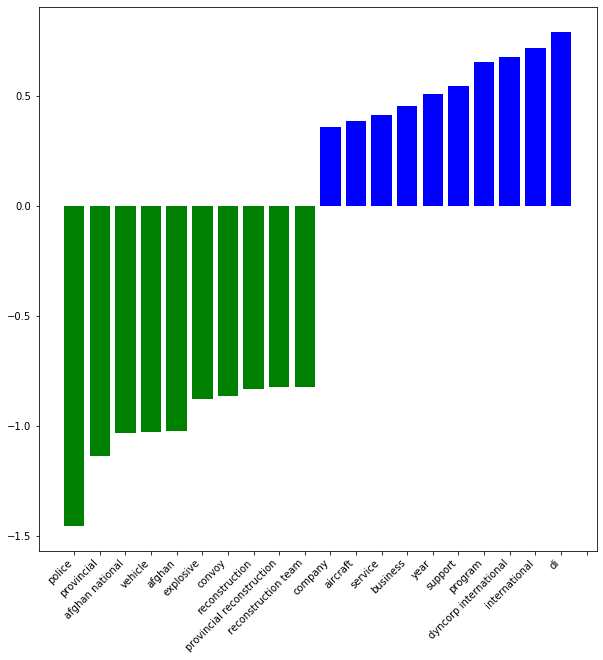

In [71]:
def feature_plot(classifier, feature_names, top_features=10):
 coef = classifier.coef_.toarray()[0]
 top_positive_coefficients = np.argsort(coef)[-top_features:]
 top_negative_coefficients = np.argsort(coef)[:top_features]
 top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
 plt.figure(figsize=(10, 10))
 colors = ['green' if c < 0 else 'blue' for c in coef[top_coefficients]]
 plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
 feature_names = np.array(feature_names)
 plt.xticks(np.arange(1 + 2 * top_features), feature_names[top_coefficients], rotation=45, ha='right')
 plt.show()
feature_plot(SVM, Tfidf_vect.get_feature_names())